In [7]:
import eniric
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from eniric.atmosphere import Atmosphere
from eniric.Qcalculator import rv_precision
from eniric.Qcalculator import quality
import colorful as cl
%matplotlib notebook

In [110]:
hdu = fits.open('car-20160325T05h28m38s-sci-gtoc-nir_A_input_TAC.fits')
data_tell = hdu[1].data
wave = data_tell['WAVE'] *0.0001  #(microns)
flux_in = data_tell['SPEC']
flux_corr = data_tell['tacflux']
trans = data_tell['mtrans']
wave

array([0.96035719, 0.96036253, 0.96036786, ..., 1.71183439, 1.71183983,
       1.71184527])

In [111]:
hdu.info()

Filename: car-20160325T05h28m38s-sci-gtoc-nir_A_input_TAC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     493   ()      
  1                1 BinTableHDU     24   108553R x 8C   ['1D', '1D', '1D', '1D', '1D', '1D', '1D', '1J']   


input flux, atm mask:  3760.160247909164 m / s  > masking the tellurics
corr flux, trans mask: 3188.871903032806 m / s  > telluric correction

Quality
input flux, atm mask:  1887.9268231003489 
corr flux, trans mask: 2198.893388603369


<IPython.core.display.Javascript object>


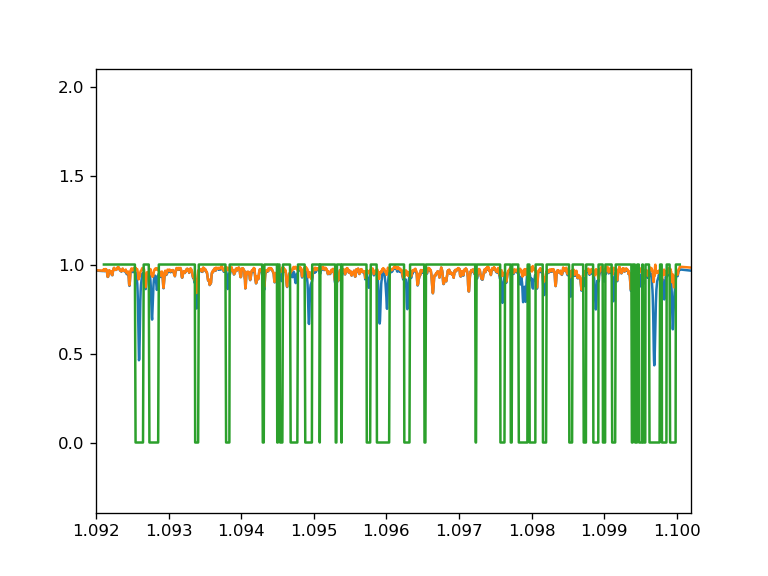

In [112]:
# Example on one order
# --------------------
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
mask = (wave > 1.092) & (wave < 1.100366) & (flux_corr > 0.)
atm = Atmosphere.from_band("Y", bary=False)
atm = atm.at(wave[mask])

# Mask the transmission below given depth. e.g. 2%-5%
atm.mask_transmission(2.0)

# Masking / Correcting the telluric lines
rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])

print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
print('\nQuality')
q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
q_corr_tell = quality(wave[mask], flux_corr[mask])
print('input flux, atm mask: ', q_mask_tell, 
      '\ncorr flux, trans mask:', q_corr_tell)

plt.figure()
plt.plot(wave, flux_in)
plt.plot(wave, flux_corr)
plt.xlim(1.092, 1.1002)
plt.plot(atm.wl, atm.mask)

In [ ]:
# Write the transmission file
with open('mtrans_carmenes.txt', 'w') as f:
    for wl, fl in zip(wave, trans):
        f.write("{} {}\n".format(wl,fl))

In [120]:
# Computing RV precision and Quality
# for all orders, bands Y J and K
# --
# Changing the atmospheric model from TAPAS to Molecfit
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
# Defining the bands
bands = ["Y", "J", "H"]
Y_mask = (wave > 0.9996668) & (wave < 1.100366)
J_mask = (wave > 1.16961 ) & (wave < 1.330443)
H_mask = (wave > 1.4995) &  (wave < 1.750583)
band_masks = [Y_mask, J_mask, H_mask]
qs_bands = []
# Loop over the bands
for band, b_mask in zip(bands, band_masks):
    print('\nBand', band, '\n-------')
    print('RV precision')
    # Removing zeros flux points
    mask = b_mask & (flux_corr > 0.)
    atm = Atmosphere.from_band(band, bary=False)
    # Obtain closest telluric model values at the wavelength values (telluric mask is super sampled).
    atm = atm.at(wave[mask])
    # Mask the transmission below given depth. e.g. 2%-5%
    atm.mask_transmission(3.0)
    
    # Masking the telluric lines
    rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
    # Corrected tellurics with Molecfit not weighted by the transmission
    rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
    if rv_corr_tell < rv_mask_tell:
        print(cl.green('> RV precision is improved'))
    else:
        print(cl.red('> RV precision is worsen'))
    
    print('\nQuality')
    q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
    q_corr_tell = quality(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', q_mask_tell, 
          '\ncorr flux, trans mask:', q_corr_tell)
    if q_corr_tell > q_mask_tell:
        print(cl.green('> Quality is improved'))
    else:
        print(cl.red('> Quality is worsen'))
        
    # Computing Quality factor in several intervals
    # needs fixing!!
    # saving all the values (q_mask, q_corr, q_wl) for each band Y, J and H
    qs = compute_Q_intervals(wave[mask], flux_in[mask], flux_corr[mask], band)
    qs_bands.append(qs)

    # plt.plot(wave[mask], atm.mask)
    # plt.plot(wave[mask], flux_in[mask])
# plt.axvspan(999.6668, 1100.366, alpha=0.2)
# plt.axvspan(1169.61, 1330.443, alpha=0.2)
# plt.axvspan(1499.5, 1750.583, alpha=0.2)


Band Y 
-------
RV precision
input flux, atm mask:  434.9406425089136 m / s  > masking the tellurics
corr flux, trans mask: 430.4798342579149 m / s  > telluric correction
> RV precision is improved

Quality
input flux, atm mask:  4861.339091365166 
corr flux, trans mask: 4895.178208574486
> Quality is improved
0.9996683474004813 0.0019993366948009624 1.1000424963841637
Nb of points in intervals:  437
1.0016676840952823 0.0020033353681905646 1.1000424963841637
Nb of points in intervals:  322
1.0036710194634728 0.0020073420389269455 1.1000424963841637
Nb of points in intervals:  494
1.0056783615023999 0.0020113567230048 1.1000424963841637
Nb of points in intervals:  532
1.0076897182254048 0.0020153794364508094 1.1000424963841637
Nb of points in intervals:  190
1.0097050976618556 0.0020194101953237113 1.1000424963841637
Nb of points in intervals:  268
1.0117245078571793 0.0020234490157143587 1.1000424963841637
Nb of points in intervals:  388
1.0137479568728935 0.002027495913745787 1.1000

1.2694601268370336 0.002538920253674067 1.330442699277994
Nb of points in intervals:  430
1.2719990470907077 0.0025439980941814153 1.330442699277994
Nb of points in intervals:  313
1.2745430451848891 0.0025490860903697784 1.330442699277994
Nb of points in intervals:  482
1.277092131275259 0.002554184262550518 1.330442699277994
Nb of points in intervals:  516
1.2796463155378095 0.002559292631075619 1.330442699277994
Nb of points in intervals:  559
1.282205608168885 0.00256441121633777 1.330442699277994
Nb of points in intervals:  403
1.284770019385223 0.002569540038770446 1.330442699277994
Nb of points in intervals:  8
1.2873395594239934 0.002574679118847987 1.330442699277994
Nb of points in intervals:  365
1.2899142385428413 0.0025798284770856827 1.330442699277994
Nb of points in intervals:  382
1.292494067019927 0.002584988134039854 1.330442699277994
Nb of points in intervals:  399
1.2950790551539668 0.0025901581103079338 1.330442699277994
Nb of points in intervals:  416
1.29766921326

In [ ]:
# Problems / Future work
# 1. Need to differentiate between fully corrected lines and not fully corrected lines
# 1. Excluding not fully corrected telluric lines
# 2. The RV precision value is wrong because the spectra are not scaled to SNR 100 in J band

In [ ]:
# Reproducing the figure 2 of Artigau 2018 

In [119]:
def compute_Q_intervals(wave, flux_in, flux_corr, band):
    """ 
    Computing the quality factor in several intervals 
    of ~2nm length in each Y, J, and H bands
    
    Reproduces the Figure 2 of Artigau 2018 in the Y, J and H bands
    --------------------------------------------------------------
    INPUTS: 
            wave = wavelength in a given band (Y, J, or H), arr
            flux_in = input flux in the same band, arr
            flux_corr = corrected flux in the same band, arr
            band = name of the band, str
    OUTPUTS: 
            qs_mask = quality factors when the tellurics are masked
            qs_corr = quality factors when the tellurics are corrected
            qs_wl = starting wl of the 2% interval
    """
    my_wl = wave[0]
    qs_mask = []
    qs_corr = []
    qs_wl = []
    while my_wl < wave[-1]:
        # Define wl interval of 2%
        delta_lambda = 0.002*my_wl
        # Mask the regions outside of the interval
        mask_2pc = (wave > my_wl) & (wave < (my_wl+delta_lambda))
        print(my_wl, delta_lambda, wave[-1])
        
        # Check the wl interval is not falling between two orders
        if np.sum(mask_2pc) == 0:
            # Increment for the next interval
            my_wl = my_wl + delta_lambda
            print('Interval undefined > between 2 orders')
            continue
        else:
            print('Nb of points in intervals: ', np.sum(mask_2pc))
            pass
        
        # Load the atmospheric transmission of Molecfit
        atm = Atmosphere.from_band(band, bary=False)
        # Obtain closest telluric model values at the wavelength values
        atm = atm.at(wave[mask_2pc])
        # Mask the transmission below given depth. e.g. 2%-5%
        atm.mask_transmission(2.0)
        
        # Compute Q over the 2% interval
        q_mask_tell = quality(wave[mask_2pc], flux_in[mask_2pc])
        q_corr_tell = quality(wave[mask_2pc], flux_corr[mask_2pc])
        
        # Save the Qs in two lists
        qs_mask.append(q_mask_tell)
        qs_corr.append(q_corr_tell)
        qs_wl.append(my_wl)
        
        # Increment for the next interval
        my_wl = my_wl + delta_lambda
    return qs_mask, qs_corr, qs_wl

In [73]:
# mask = (wave > 1.17) & (wave < 1.17574)
ind = trans[mask] > 0.97
fl = flux_in[mask]
tr = trans[mask]
ww = wave[mask]
res = fl - tr
# Residuals
avg_res = np.mean(res[ind])
print(avg_res)
max_res = avg_res + np.std(res[ind])
min_res = avg_res - np.std(res[ind])
res_10percent = avg_res*0.1

plt.subplot(212, sharex=ax1)
plt.plot(wave[mask], res, 'C0.')
plt.plot(ww[ind], res[ind], 'C1.')
plt.plot(ww[ind], ww[ind]*0. + max_res, 'k--')
plt.plot(ww[ind], ww[ind]*0. + min_res, 'r--')
plt.plot(ww[ind], ww[ind]*0 + (avg_res + abs(res_10percent)), 'k-')
plt.plot(ww[ind], ww[ind]*0 + (avg_res - abs(res_10percent)), 'r-')

0.035153980985366616


<IPython.core.display.Javascript object>


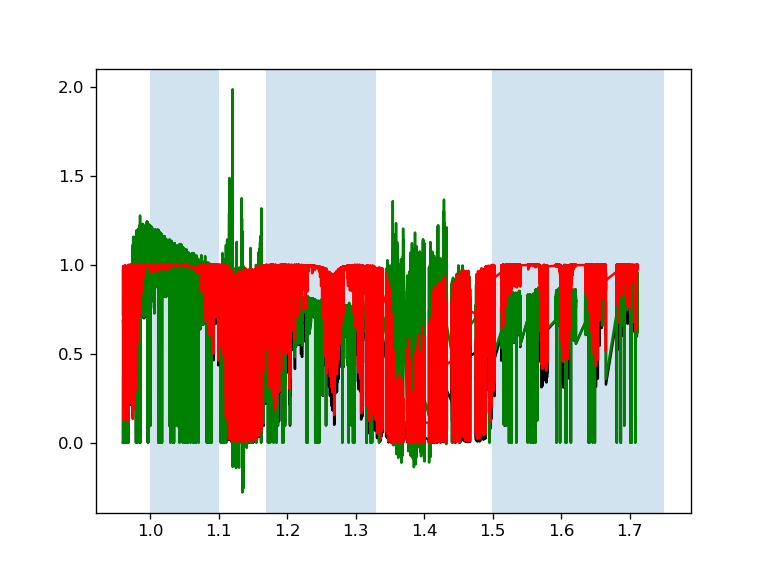

In [66]:
plt.figure()
wl_mask = Y_mask
# plt.plot(wave[mask], flux_in[mask])
plt.plot(wave, flux_in, 'k-', label='Input')
plt.plot(wave, flux_corr, 'g-', label='Corrected')
plt.plot(wave, data_tell['mtrans'], 'r-', label='Trans')
plt.axvspan(0.9996668, 1.100366, alpha=0.2)
plt.axvspan(1.16961, 1.330443, alpha=0.2)
plt.axvspan(1.4995, 1.750583, alpha=0.2)
# plt.legend()